# ** MLB Player Digital Engagement Competition**&#x1f600;

 
## I think this competition is a competition that predicts future fan engagement(such as "reaction" and "behavior") with the digital content of each MLB player ID . We will predict four different measures of engagement (target1-target4), each quantified on a scale of 0-100 with a different index.
(It's easy to imagine that you can write on twitter about players or access some site for some players and so on.)

## If you find it useful, I would be grateful if you could **upvote**! Thank you for those who have upvote on other notebooks.

## Also, basically, I referred the starter of this secretariat and understood EDA (partial excerpt). Thank you very much.

## Please also upvote this.

https://www.kaggle.com/ryanholbrook/getting-started-with-mlb-player-digital-engagement

In [ ]:
import gc
import sys
import warnings
from pathlib import Path

import os

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
warnings.simplefilter("ignore")

# 0. What to predict (look from the submission file)

In [ ]:
example_sample_submission = pd.read_csv("../input/mlb-player-digital-engagement-forecasting/example_sample_submission.csv")
example_sample_submission

I think this competition is a competition that predicts future fan engagement(such as "reaction" and "behavior") with the digital content of each NLB player ID . 
We will predict four different measures of engagement (target1-target4), each quantified on a scale of 0-100 with a different index.

## 0.1 Guess from what information? (I will look at the test data first)

In [ ]:
example_test = pd.read_csv("../input/mlb-player-digital-engagement-forecasting/example_test.csv")
example_test

At first glance, it doesn't seem like you can immediately see the player ID that appears in the submission. It seems that various information is included in json format.


The test data consists of one line of data per day.


For example, using a function from the starter code, it can be expanded as follows.

In [ ]:
# Helper function to unpack json found in daily data
def unpack_json(json_str):
    return np.nan if pd.isna(json_str) else pd.read_json(json_str)

In [ ]:
example_test.head(3)

Visualize the example_test["games"].iloc[0] 

In [ ]:
unpack_json(example_test["games"].iloc[0])

Visualize the example_test["rosters"].iloc[0] 

In [ ]:
unpack_json(example_test["rosters"].iloc[0])

From the information in this area, I think it is a competition to estimate the expected value of the evaluation items target1 to 4 on the next day for each player id.

--------- Based on the above, we will look at other data such as train data ---------

# 1. train.csv

In [ ]:
# It will take some time to load.
training = pd.read_csv("../input/mlb-player-digital-engagement-forecasting/train.csv")
training

In [ ]:
#date is converted to datetime
training['date'] = pd.to_datetime(training['date'], format="%Y%m%d")

In [ ]:
training.info()

Data for 1216 days. No null data. There are nan data here and there.

---------------------------------------------------------------------

## From here **Let's take a look at one json where there is data for each column**.

As mentioned above, the contents of train.csv are also in json file format in one cell, and it has a complicated shape like dataframe is further contained.

(According to the result, it is an image that about 11 DataFrames (although it is a little small even if there is nan) are hanging as the amount of information for one day of data for 1216 days in total, which is a considerable amount of information. is.

So it's a little long from here. You may just grab the image and read it through. )

In [ ]:
training.columns

It is troublesome to input one by one, so I will omit NaN and make the nth (0 is the top) sample as a dataframe and create a function to see the column name and contents.

In [ ]:
def exshow(col,n):
    tmp = training[col]
    tmp = tmp.dropna()
    tmpdf = unpack_json(tmp.iloc[n])
    print(tmpdf.columns)
    return tmpdf

## 1.1 nextDayPlayerEngagement (column 1 of train.csv)
Nested JSON containing all modeling targets from the following day.

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("nextDayPlayerEngagement",0)
tmpdf

* engagementMetricsDate - date of player engagement metrics, based on US Pacific Time (aligns with previous day’s games, rosters, on-field statistics, transactions, awards, etc.).
* playerId
* target1
* target2
* target3
* target4


target1-target4 are each daily indexes of digital engagement on a 0-100 scale.

From here, plyaerId and targets1 to 4 from the next day onwards are pulled out.

## 1.2 games(column 2 of train.csv)
Nested JSON containing all game information for a given day. Includes spring training and exhibition games along with regular season, Postseason, and All-Star games.

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("games",1) # 0番目（1番上はデータが一行しかなかったので、1にしました。)
tmpdf

Please open ↓ for the meaning of the column. (Because it is long, I hide it.)

* gamePk - Unique identifier for a game.
* gameType - Game type, various types can be found here.
* season
* gameDate
* gameTimeUTC - First pitch time in UTC.
* resumeDate - Time game was resumed (if abandoned, otherwise null).
* resumedFrom - Time game was originally abandoned (if abandoned, otherwise null).
* codedGameState - Game status code, various types can be found here.
* detailedGameState - Game status, various types can be found here.
* isTie - Boolean, true if game ended in a tie.
* gameNumber - Game number flag to distinguish double headers - 1 or 2.
* doubleHeader - Y for DH, N for single game, S for split-ticket.
* dayNight - Day or night flag for scheduled start time.
* scheduledInnings - Scheduled number of innings.
* gamesInSeries - Number of games in current series.
* seriesDescription - Text description of current series.
* homeId - Unique identifier for home team.
* homeName - Home team name.
* homeAbbrev - Home team abbreviation.
* homeWins - Number of current wins on season for home team.
* homeLosses - Number of current losses on season for home team.
* homeWinPct - Current winning percentage for home team.
* homeWinner - Boolean, true if home team wins.
* homeScore - Runs scored by home team.
* awayId - Unique identifier for away team.
* awayName - Unique identifier for away team.
* awayAbbrev - Away team abbreviation.
* awayWins - Number of current wins on season for away team.
* awayLosses - Number of current losses on season for away team.
* awayWinPct - Current winning percentage for away team.
* awayWinner - Boolean, true if away team wins.
* awayScore - Runs scored by away team.

## 1.3 rosters(column 3 of train.csv)
Nested JSON that contains all the roster information for a particular day. Includes in-season and off-season team rosters.

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("rosters",0) 
tmpdf

* playerId - Unique identifier for a player.
* gameDate
* teamId - teamId that player is on that date.
* statusCode - Roster status abbreviation.
* status - Descriptive roster status.

## 1.4 playerBoxScores(column 4 of train.csv)
Nested JSON containing game stats aggregated at the player game level for a given day. Includes regular

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("playerBoxScores",0) 
tmpdf.head(5)

Please open ↓ for the meaning of the column. (Because it is long, I hide it.)

* home - Binary, 1 if home team, 0 if away.
* gamePk - unique identifier for game.
* gameDate
* gameTimeUTC - First pitch time in UTC.
* teamId - Unique identifier for team.
* teamName
* playerId - Unique identifier for player.
* playerName
* jerseyNum
* positionCode - Number position code, details are here.
* positionName - Text position display, details are here.
* positionType - Position group, details are here.
* battingOrder - Format: “###”, where the first digit indicates the batting order spot, and the second two digits indicate the sequence in which that player occupied that batting order spot. Examples: “300”, which indicates the starter in the third spot in the batting order; “903,” which indicates the fourth player (after 900, 901 and 902) occupy the ninth spot in the batting order. Only populates if appeared in game.
* gamesPlayedBatting - 1 if player entered the game as a batter, runner or fielder.
* flyOuts - Game total fly outs.
* groundOuts - Game total ground outs.
* runsScored - Game total runs scored.
* doubles - Game total doubles.
* triples - Game total triples.
* homeRuns - Game total home runs.
* strikeOuts - Game total strike outs.
* baseOnBalls - Game total walks.
* intentionalWalks - Game total intentional walks.
* hits - Game total hits.
* hitByPitch - Game total hit by pitches.
* atBats - Game total at-bats.
* caughtStealing - Game total caught stealing.
* stolenBases - Game total stolen bases.
* groundIntoDoublePlay - Game total double plays grounded into.
* groundIntoTriplePlay - Game total triple plays grounded into.
* plateAppearances - Game total plate appearances.
* totalBases - Game total bases.
* rbi - Game total runs batted in.
* leftOnBase - Game total runners left on base.
* sacBunts - Game total sacrifice bunts.
* sacFlies - Game total sacrifice flies.
* catchersInterference - Game total catchers interference reached on.
* pickoffs - Game total number of times picked off base.
* gamesPlayedPitching- Binary, 1 if player entered the game as a pitcher.
* gamesStartedPitching- Binary, 1 if player was game’s starting pitcher.
* completeGamesPitching - Binary, 1 if credited with complete game.
* shutoutsPitching - Binary, 1 if credited with shutout.
* winsPitching - Binary, 1 if credited with win.
* lossesPitching - Binary, 1 if credited with loss.
* flyOutsPitching - Game total of flyouts allowed.
* airOutsPitching - Game total of air outs (flyouts + popouts) allowed.
* groundOutsPitching - Game total ground outs allowed.
* runsPitching - Game total runs allowed.
* doublesPitching - Game total doubles allowed.
* triplesPitching - Game total triples allowed.
* homeRunsPitching - Game total home runs allowed.
* strikeOutsPitching - Game total strike outs allowed.
* baseOnBallsPitching - Game total walks allowed.
* intentionalWalksPitching - Game total intentional walks allowed.
* hitsPitching - Game total hits allowed.
* hitByPitchPitching - Game total hit by pitches allowed.
* atBatsPitching - Game total at-bats against.
* caughtStealingPitching - Game total caught stealing against.
* stolenBasesPitching - Game total stolen bases allowed.
* inningsPitched - Game total innings pitched.
* saveOpportunities - Binary, 1 if credited with save opportunity.
* earnedRuns - Game total earned runs allowed.
* battersFaced - Game total batters faced.
* outsPitching - Game total outs recorded.
* pitchesThrown - Game total number of pitches thrown.
* balls - Game total balls thrown.
* strikes - Game total strikes thrown.
* hitBatsmen - Game total hit batters.
* balks - Game total balks.
* wildPitches - Game total number of wild pitches thrown.
* pickoffsPitching - Game total number of pickoffs.
* rbiPitching - Game total number of runs batted in allowed.
* inheritedRunners - Game total of inherited runners assumed.
* inheritedRunnersScored- Game total of inherited runners that scored.
* catchersInterferencePitching - Game total of catcher’s interference occurred by battery.
* sacBuntsPitching - Game total sacrifice bunts allowed.
* sacFliesPitching - Game total sacrifice flies allowed.
* saves - Binary, 1 if credited with save.
* holds - Binary, 1 if credited with hold.
* blownSaves - Binary, 1 if credited with blown save.
* assists - Game total number of assists.
* putOuts - Game total number of putouts.
* errors - Game total number of errors.
* chances - Game total fielding chances.

## 1.5 teamBoxScores(column 5 of train.csv)
Nested JSON containing game stats aggregated at the team game level for a given day. Includes regular season, Postseason, and All-Star games.

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("teamBoxScores",0) 
tmpdf.head(5)

Please open ↓ for the meaning of the column. (Because it is long, I hide it.)

* home - Binary, 1 if home team, 0 if away.
* teamId - unique identifier for team.
* gamePk - unique identifier for game.
* gameDate
* gameTimeUTC - First pitch time in UTC.
* flyOuts - Game total fly outs.
* groundOuts - Game total ground outs.
* runsScored - Game total runs scored.
* doubles - Game total doubles.
* triples - Game total triples.
* homeRuns - Game total home runs.
* strikeOuts - Game total strike outs.
* baseOnBalls - Game total walks.
* intentionalWalks - Game total intentional walks.
* hits - Game total hits.
* hitByPitch - Game total hit by pitches.
* atBats - Game total at-bats.
* caughtStealing - Game total caught stealing.
* stolenBases - Game total stolen bases.
* groundIntoDoublePlay - Game total double plays grounded into.
* groundIntoTriplePlay - Game total triple plays grounded into.
* plateAppearances - Game total plate appearances.
* totalBases - Game total bases.
* rbi - Game total runs batted in.
* leftOnBase - Game total runners left on base.
* sacBunts - Game total sacrifice bunts.
* sacFlies - Game total sacrifice flies.
* catchersInterference - Game total catcher’s interference reached on.
* pickoffs - Game total number of times picked off base.
* airOutsPitching - Game total of air outs (flyouts + popouts) allowed.
* groundOutsPitching - Game total ground outs allowed.
* runsPitching - Game total runs allowed.
* doublesPitching - Game total doubles allowed.
* triplesPitching - Game total triples allowed.
* homeRunsPitching - Game total home runs allowed.
* strikeOutsPitching - Game total strike outs allowed.
* baseOnBallsPitching - Game total walks allowed.
* intentionalWalksPitching - Game total intentional walks allowed.
* hitsPitching - Game total hits allowed.
* hitByPitchPitching - Game total hit by pitches allowed.
* atBatsPitching - Game total at-bats against.
* caughtStealingPitching - Game total caught stealing against.
* stolenBasesPitching - Game total stolen bases allowed.
* inningsPitched - Game total innings pitched.
* earnedRuns - Game total earned runs allowed.
* battersFaced - Game total batters faced.
* outsPitching - Game total outs recorded.
* hitBatsmen - Game total hit batters.
* balks - Game total balks.
* wildPitches - Game total number of wild pitches thrown.
* pickoffsPitching - Game total number of pickoffs.
* rbiPitching - Game total number of runs batted in allowed.
* inheritedRunners - Game total of inherited runners assumed.
* inheritedRunnersScored- Game total of inherited runners that scored.
* catchersInterferencePitching - Game total of catcher’s interference occurred by battery.
* sacBuntsPitching - Game total sacrifice bunts allowed.
* sacFliesPitching - Game total sacrifice flies allowed.

## 1.6 transactions(column 6 of train.csv)
Nested JSON containing all transaction information involving MLB teams for a given day.

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("transactions",1) 
tmpdf

* transactionId - Unique identifier for a transaction.
* playerId - Unique identifier for a player.
* playerName
* date
* fromTeamId - Unique identifier for the team a player goes from.
* fromTeamName
* toTeamId - Unique identifier for the team a player goes to.
* toTeamName
* effectiveDate
* resolutionDate
* typeCode - Transaction status abbreviation.
* typeDesc - Transaction status description.
* description - Text description of transaction.

## 1.7 standings(column 7 of train.csv)
Nested JSON containing all standings information involving MLB teams for a given day.

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("standings",0) 
tmpdf.head(5)

Please open ↓ for the meaning of the column. (Because it is long, I hide it.)

* season
* gameDate
* divisionId - Unique identifier of the division that this team plays in.
* teamId - Unique identifier for a team.
* teamName
* streakCode - Abbreviation of team’s current win or loss streak. First letter indicates winning or losing, number is the number of games.
* divisionRank - Team’s current rank in their division.
* leagueRank - Team’s current rank in their league.
* wildCardRank - Team’s current rank for a wildcard berth.
* leagueGamesBack - Games back in team’s league.
* sportGamesBack - Games back in all of MLB.
* divisionGamesBack - Games back in team’s division.
* wins - Current wins.
* losses - Current losses.
* pct - Current winning percentage.
* runsAllowed - Runs allowed on the season.
* runsScored - Runs scored on the season.
* divisionChamp - true if team has clinched the division title.
* divisionLeader - true if team is leading the division race.
* wildCardLeader - true if team is wildcard leader.
* eliminationNumber - number of games (team losses + opponent wins) before eliminated from the division race.
* wildCardEliminationNumber - number of games (team losses + opponent wins) before eliminated from the wildcard race.
* homeWins - Home wins on the season.
* homeLosses - Home losses on the season.
* awayWins - Away wins on the season.
* awayLosses - Away losses on the season.
* lastTenWins - Wins in the last 10 games.
* lastTenLosses - Losses in the last 10 games.
* extraInningWins - Wins in extra innings on the season.
* extraInningLosses - Losses in extra innings on the season.
* oneRunWins - Wins by one run on the season.
* oneRunLosses - Losses by one run on the season.
* dayWins - Day game wins on the season.
* dayLosses Day game losses on the season.
* nightWins - Night game wins on the season.
* nightLosses - Night game losses on the season.
* grassWins - Grass field wins on the season.
* grassLosses - Grass field losses on the season.
* turfWins - Turf field wins on the season.
* turfLosses - Turf field losses on the season.
* divWins - Wins against division opponents on the season.
* divLosses - Losses against division opponents on the season.
* alWins - Wins against AL teams on the season.
* alLosses - Losses against AL teams on the season.
* nlWins - Wins against NL teams on the season.
* nlLosses - Losses against NL teams on the season.
* xWinLossPct - Expected winning percentage based on runs scored and allowed.

## 1.8 awards(column 8 of train.csv)
Nested JSON containing all awards or honors handed out on a given day.

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("awards",0) 
tmpdf

* awardId
* awardName
* awardDate - Date award was given.
* awardSeason - Season award was from.
* playerId - Unique identifier for a player.
* playerName
* awardPlayerTeamId

## 1.9 events(column 9 of train.csv)
Nested JSON containing all on-field game events for a given day. Includes regular season and Postseason games.

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("events",0) 
tmpdf.head(5)

Please open ↓ for the meaning of the column. (Because it is long, I hide it.)

* gamePk - unique identifier for game.
* gameDate
* gameTimeUTC - First pitch time in UTC.
* season
* gameType - Game type, various types can be found here.
* playId - Statcast play guid.
* eventId
* inning - Inning AB occurred.
* halfInning- “top” or “bottom” inning indicator.
* homeScore - Home score at start of the event.
* awayScore - Away score at start of the event.
* menOnBase - Split used if runner on base – ie (RISP, Empty).
* atBatIndex - At-Bat index number, begins with 0.
* atBatDesc - Play-by-play description of AB.
* atBatEvent - Event type result of the atBat, various types can be found here.
* hasOut - Binary, 1 if runner is out on play.
* pitcherTeamId - Unique identifier for pitching team.
* isPitcherHome - Binary, 1 if pitcher is home team.
* pitcherTeam - team name of pitching team.
* hitterTeamId - Unique identifier for hitting team.
* hitterTeam - Team name of hitting team.
* pitcherId
* pitcherName
* isStarter - Binary, 1 if player was game’s starting pitcher.
* pitcherHand - Player throw hand: “L”,”R”.
* hitterId
* hitterName
* batSide - Player bat side: “L”,”R”.
* pitchNumber - Pitch sequence number of AB.
* balls - Ball count after the event.
* strikes - Strike count after the event.
* isGB - Binary, 1 if at bat is a ground ball.
* isLD - Binary, 1 if at bat is a line drive.
* isFB - Binary, 1 if at bat is a fly ball.
* isPU - Binary, 1 if at bat is a pop up.
* launchSpeed - Measured speed of the hit ball.
* launchAngle - Vertical angle relative to the horizon at which the hit was launched.
* totalDistance - Total distance ball traveled.
* event - Events that may occur during an at-bat: strikeout, groundout, substitutions, stolen base, wild pitch, game advisory, etc.
* description - Text description of event.
* rbi - Number of runs batted in during AB.
* pitchType - Pitch type classification code, various types can be found here.
* call - Pitch or throw result classification code, various types can be found here.
* outs - Current/Final outs of AB.
* inPlay - True/False if ball was hit into play.
* isPaOver - Binary, 1 if this event is the end of the plate appearance.
* startSpeed - Speed in MPH of the ball at 50 feet in front of home plate.
* endSpeed - Speed in MPH of the ball as it crosses the front edge of home plate (0,0 in the x axis).
* nastyFactor - Evaluates several properties of each pitch, and rates the "nastiness" of the pitch on a scale from 0-100.
* breakAngle - Degrees clockwise (batter’s view) that the plane of the pitch deviates from the vertical.
* breakLength - Max distance that the pitch separates from the straight line between pitch start and pitch end.
* breakY - Distance from home plate where the break is greatest.
* spinRate - Rate of spin on the ball after it was released by pitcher in RPMs.
* spinDirection - The axis of rotation for the ball at release given as an angle that reflects how the spin will influence the ball trajectory. Pure back-spin is 180 degrees, pure side-spin that puts the ball to the 1b side is 90 degrees, pure-side spin that pulls the ball to the 3b side is 270 degrees, and pure top-spin is 0 or 360 degrees.
* pX - Horizontal position in feet of the ball as it crosses the front axis of home plate.
* pZ - Vertical position in feet above home plate of the ball as it crosses the front axis of home plate.
* aX - Ball acceleration on the z axis.
* aY - Ball acceleration on the y axis.
* aZ - Ball acceleration on the z axis.
* pfxX - Horizontal movement of the ball in inches.
* pfxZ - Vertical movement of the ball in inches.
* vX0 - Velocity of the ball from the x axis.
* vY0 - Velocity of the ball from the y axis; this is negative because 0,0,0 is behind the batter and the ball travels from pitcher mound towards 0,0,0.
* vZ0 - Velocity of the ball from the z axis.
* x - X coordinate where pitch crossed front of home plate.
* y - Y coordinate where pitch crossed front of home plate.
* x0 - Coordinate location of the ball at the point it was released from the pitchers hand on the x axis (time = 0).
* y0 - Coordinate location of the ball at the point it was released from the pitchers hand on the y axis (time = 0).
* z0 - Coordinate location of the ball at the point it was released from the pitchers hand on the z axis (time = 0).
* type - Type of event, either ‘pitch’ or ‘action’
* zone - Zone location number - see image below.

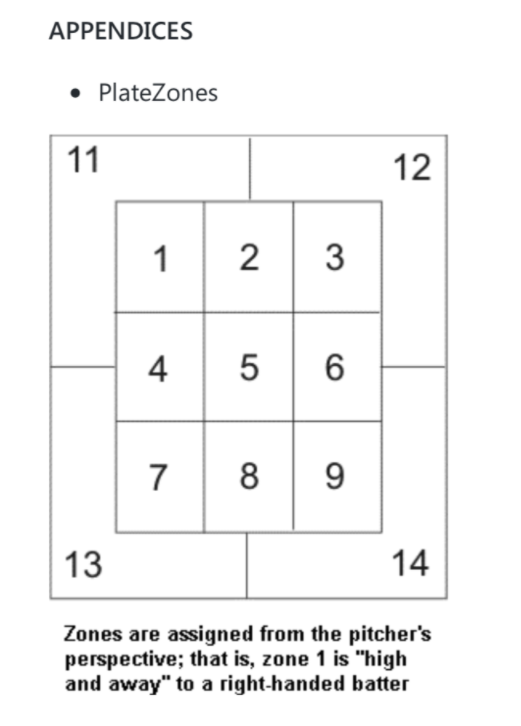

from data page on kaggle : https://www.kaggle.com/c/mlb-player-digital-engagement-forecasting/data

## 1.10 playerTwitterFollowers(column 10 of train.csv)
Nested JSON containing some players’ number of Twitter followers on that day.

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("playerTwitterFollowers",0) 
tmpdf.head(3)

Twitter following data was collected by MLB from Twitter APIs for Major League players, on the first of each month, dating back to 1/1/2018. This dataset is not exhaustive of all players over all months, as not every player has/had a Twitter account, players may create/delete/reinstate accounts at random, or other scenarios preventing follower data from being collected on a given date.

* date - Date of follower count.
* playerId - Unique identifier for a player.
* playerName
* accountName - Name on player twitter account.
* twitterHandle - Player twitter handle.
* numberOfFollowers - Number of followers

## 1.11 teamTwitterFollowers(column 11 of train.csv)
 Nested JSON containing each team’s number of Twitter followers on that day.

In [ ]:
training.head(3)

In [ ]:
tmpdf = exshow("teamTwitterFollowers",0) 
tmpdf.head(3)

Twitter following data was collected by MLB from Twitter APIs for all 30 Major League teams, on the first of each month, dating back to 1/1/2018.

* date - Date of follower count.
* teamId - Unique identifier for a team.
* teamName
* accountName - Name on team twitter account.
* twitterHandle - Team twitter handle.
* numberOfFollowers - Number of followers.

Finally, the contents have been confirmed. Thank you for your support. .. .

# 2. Other additional data ( awards.csv, players.csv, seasons.csv, teams.csv)

## 2.1 Practice the widget that was in the starter (I thought I could do this ...)

In [ ]:
df_names = ['seasons', 'teams', 'players', 'awards']

path = "../input/mlb-player-digital-engagement-forecasting"

In [ ]:
kaggle_data_tabs = widgets.Tab()
# Display each DataFrame in widgets as a tab inside children
kaggle_data_tabs.children = list([widgets.Output() for df_name in df_names])

In [ ]:
for index in range(len(df_names)):
    # Set tab title
    kaggle_data_tabs.set_title(index, df_names[index])
    
    df = pd.read_csv(os.path.join(path,df_names[index]) + ".csv")
    
    # Embed DataFrame in each tab
    with kaggle_data_tabs.children[index]:
        display(df)

In [ ]:
display(kaggle_data_tabs)

-----------I will look at each one in detail-----------

## 2.2 Seasons.csv

In [ ]:
seasons = pd.read_csv("../input/mlb-player-digital-engagement-forecasting/seasons.csv")
seasons

* seasonId
* seasonStartDate
* seasonEndDate
* preSeasonStartDate
* preSeasonEndDate
* regularSeasonStartDate
* regularSeasonEndDate
* lastDate1stHalf
* allStarDate
* firstDate2ndHalf
* postSeasonStartDate
* postSeasonEndDate

## 2.3 teams.csv

In [ ]:
teams = pd.read_csv("../input/mlb-player-digital-engagement-forecasting/teams.csv")
teams.head(3)

## teams.csv
* id - teamId
* name
* teamName
* teamCode
* shortName
* abbreviation
* locationName
* leagueId
* leagueName
* divisionId
* divisionName
* venueId
* venueName

## 2.4 players.csv

In [ ]:
players = pd.read_csv("../input/mlb-player-digital-engagement-forecasting/players.csv")
players.head(3)

* playerId - Unique identifier for a player.
* playerName
* DOB - Player’s date of birth.
* mlbDebutDate
* birthCity
* birthStateProvince
* birthCountry
* heightInches
* weight
* primaryPositionCode - Player’s primary position code, details are here.
* primaryPositionName - player’s primary position, details are here.
* playerForTestSetAndFuturePreds - Boolean, true if player is among those for whom predictions are to be made in test data

## 2.5 awards.csv

In [ ]:
awards = pd.read_csv("../input/mlb-player-digital-engagement-forecasting/awards.csv")
awards.head(3)

This file has awards won by players in the training set prior to the beginning of the daily data (i.e. before 2018).

* awardDate - Date award was given.
* awardSeason - Season award was from.
* awardId
* awardName
* playerId - Unique identifier for a player.
* playerName
* awardPlayerTeamId

# 3. Data Merge

For the time being,  this is a copy of starter https://www.kaggle.com/ryanholbrook/getting-started-with-mlb-player-digital-engagement. It will take some time.

In [ ]:
for name in df_names:
    globals()[name] = pd.read_csv(os.path.join(path,name)+ ".csv")

In [ ]:
#### Unnest various nested data within training (daily) data ####
daily_data_unnested_dfs = pd.DataFrame(data = {
  'dfName': training.drop('date', axis = 1).columns.values.tolist()
  })

daily_data_unnested_dfs['df'] = [pd.DataFrame() for row in 
  daily_data_unnested_dfs.iterrows()]

for df_index, df_row in daily_data_unnested_dfs.iterrows():
    nestedTableName = str(df_row['dfName'])
    
    date_nested_table = training[['date', nestedTableName]]
    
    date_nested_table = (date_nested_table[
      ~pd.isna(date_nested_table[nestedTableName])
      ].
      reset_index(drop = True)
      )
    
    daily_dfs_collection = []
    
    for date_index, date_row in date_nested_table.iterrows():
        daily_df = unpack_json(date_row[nestedTableName])
        
        daily_df['dailyDataDate'] = date_row['date']
        
        daily_dfs_collection = daily_dfs_collection + [daily_df]

    unnested_table = pd.concat(daily_dfs_collection,
      ignore_index = True).set_index('dailyDataDate').reset_index()

    # Creates 1 pandas df per unnested df from daily data read in, with same name
    globals()[df_row['dfName']] = unnested_table    
    
    daily_data_unnested_dfs['df'][df_index] = unnested_table

del training
gc.collect()



#### Get some information on each date in daily data (using season dates of interest) ####
dates = pd.DataFrame(data = 
  {'dailyDataDate': nextDayPlayerEngagement['dailyDataDate'].unique()})

dates['date'] = pd.to_datetime(dates['dailyDataDate'].astype(str))

dates['year'] = dates['date'].dt.year
dates['month'] = dates['date'].dt.month

dates_with_info = pd.merge(
  dates,
  seasons,
  left_on = 'year',
  right_on = 'seasonId'
  )

dates_with_info['inSeason'] = (
  dates_with_info['date'].between(
    dates_with_info['regularSeasonStartDate'],
    dates_with_info['postSeasonEndDate'],
    inclusive = True
    )
  )

dates_with_info['seasonPart'] = np.select(
  [
    dates_with_info['date'] < dates_with_info['preSeasonStartDate'], 
    dates_with_info['date'] < dates_with_info['regularSeasonStartDate'],
    dates_with_info['date'] <= dates_with_info['lastDate1stHalf'],
    dates_with_info['date'] < dates_with_info['firstDate2ndHalf'],
    dates_with_info['date'] <= dates_with_info['regularSeasonEndDate'],
    dates_with_info['date'] < dates_with_info['postSeasonStartDate'],
    dates_with_info['date'] <= dates_with_info['postSeasonEndDate'],
    dates_with_info['date'] > dates_with_info['postSeasonEndDate']
  ], 
  [
    'Offseason',
    'Preseason',
    'Reg Season 1st Half',
    'All-Star Break',
    'Reg Season 2nd Half',
    'Between Reg and Postseason',
    'Postseason',
    'Offseason'
  ], 
  default = np.nan
  )

#### Add some pitching stats/pieces of info to player game level stats ####

player_game_stats = (playerBoxScores.copy().
  # Change team Id/name to reflect these come from player game, not roster
  rename(columns = {'teamId': 'gameTeamId', 'teamName': 'gameTeamName'})
  )

# Adds in field for innings pitched as fraction (better for aggregation)
player_game_stats['inningsPitchedAsFrac'] = np.where(
  pd.isna(player_game_stats['inningsPitched']),
  np.nan,
  np.floor(player_game_stats['inningsPitched']) +
    (player_game_stats['inningsPitched'] -
      np.floor(player_game_stats['inningsPitched'])) * 10/3
  )

# Add in Tom Tango pitching game score (https://www.mlb.com/glossary/advanced-stats/game-score)
player_game_stats['pitchingGameScore'] = (40
#     + 2 * player_game_stats['outs']
    + 1 * player_game_stats['strikeOutsPitching']
    - 2 * player_game_stats['baseOnBallsPitching']
    - 2 * player_game_stats['hitsPitching']
    - 3 * player_game_stats['runsPitching']
    - 6 * player_game_stats['homeRunsPitching']
    )

# Add in criteria for no-hitter by pitcher (individual, not multiple pitchers)
player_game_stats['noHitter'] = np.where(
  (player_game_stats['gamesStartedPitching'] == 1) &
  (player_game_stats['inningsPitched'] >= 9) &
  (player_game_stats['hitsPitching'] == 0),
  1, 0
  )

player_date_stats_agg = pd.merge(
  (player_game_stats.
    groupby(['dailyDataDate', 'playerId'], as_index = False).
    # Some aggregations that are not simple sums
    agg(
      numGames = ('gamePk', 'nunique'),
      # Should be 1 team per player per day, but adding here for 1 exception:
      # playerId 518617 (Jake Diekman) had 2 games for different teams marked
      # as played on 5/19/19, due to resumption of game after he was traded
      numTeams = ('gameTeamId', 'nunique'),
      # Should be only 1 team for almost all player-dates, taking min to simplify
      gameTeamId = ('gameTeamId', 'min')
      )
    ),
  # Merge with a bunch of player stats that can be summed at date/player level
  (player_game_stats.
    groupby(['dailyDataDate', 'playerId'], as_index = False)
    [['runsScored', 'homeRuns', 'strikeOuts', 'baseOnBalls', 'hits',
      'hitByPitch', 'atBats', 'caughtStealing', 'stolenBases',
      'groundIntoDoublePlay', 'groundIntoTriplePlay', 'plateAppearances',
      'totalBases', 'rbi', 'leftOnBase', 'sacBunts', 'sacFlies',
      'gamesStartedPitching', 'runsPitching', 'homeRunsPitching', 
      'strikeOutsPitching', 'baseOnBallsPitching', 'hitsPitching',
      'inningsPitchedAsFrac', 'earnedRuns', 
      'battersFaced','saves', 'blownSaves', 'pitchingGameScore', 
      'noHitter'
      ]].
    sum()
    ),
  on = ['dailyDataDate', 'playerId'],
  how = 'inner'
  )

#### Turn games table into 1 row per team-game, then merge with team box scores ####
# Filter to regular or Postseason games w/ valid scores for this part
games_for_stats = games[
  np.isin(games['gameType'], ['R', 'F', 'D', 'L', 'W', 'C', 'P']) &
  ~pd.isna(games['homeScore']) &
  ~pd.isna(games['awayScore'])
  ]

# Get games table from home team perspective
games_home_perspective = games_for_stats.copy()

# Change column names so that "team" is "home", "opp" is "away"
games_home_perspective.columns = [
  col_value.replace('home', 'team').replace('away', 'opp') for 
    col_value in games_home_perspective.columns.values]

games_home_perspective['isHomeTeam'] = 1

# Get games table from away team perspective
games_away_perspective = games_for_stats.copy()

# Change column names so that "opp" is "home", "team" is "away"
games_away_perspective.columns = [
  col_value.replace('home', 'opp').replace('away', 'team') for 
    col_value in games_away_perspective.columns.values]

games_away_perspective['isHomeTeam'] = 0

# Put together games from home/away perspective to get df w/ 1 row per team game
team_games = (pd.concat([
  games_home_perspective,
  games_away_perspective
  ],
  ignore_index = True)
  )

# Copy over team box scores data to modify
team_game_stats = teamBoxScores.copy()

# Change column names to reflect these are all "team" stats - helps 
# to differentiate from individual player stats if/when joining later
team_game_stats.columns = [
  (col_value + 'Team') 
  if (col_value not in ['dailyDataDate', 'home', 'teamId', 'gamePk',
    'gameDate', 'gameTimeUTC'])
    else col_value
  for col_value in team_game_stats.columns.values
  ]

# Merge games table with team game stats
team_games_with_stats = pd.merge(
  team_games,
  team_game_stats.
    # Drop some fields that are already present in team_games table
    drop(['home', 'gameDate', 'gameTimeUTC'], axis = 1),
  on = ['dailyDataDate', 'gamePk', 'teamId'],
  # Doing this as 'inner' join excludes spring training games, postponed games,
  # etc. from original games table, but this may be fine for purposes here 
  how = 'inner'
  )

team_date_stats_agg = (team_games_with_stats.
  groupby(['dailyDataDate', 'teamId', 'gameType', 'oppId', 'oppName'], 
    as_index = False).
  agg(
    numGamesTeam = ('gamePk', 'nunique'),
    winsTeam = ('teamWinner', 'sum'),
    lossesTeam = ('oppWinner', 'sum'),
    runsScoredTeam = ('teamScore', 'sum'),
    runsAllowedTeam = ('oppScore', 'sum')
    )
   )

# Prepare standings table for merge w/ player digital engagement data
# Pick only certain fields of interest from standings for merge
standings_selected_fields = (standings[['dailyDataDate', 'teamId', 
  'streakCode', 'divisionRank', 'leagueRank', 'wildCardRank', 'pct'
  ]].
  rename(columns = {'pct': 'winPct'})
  )

# Change column names to reflect these are all "team" standings - helps 
# to differentiate from player-related fields if/when joining later
standings_selected_fields.columns = [
  (col_value + 'Team') 
  if (col_value not in ['dailyDataDate', 'teamId'])
    else col_value
  for col_value in standings_selected_fields.columns.values
  ]

standings_selected_fields['streakLengthTeam'] = (
  standings_selected_fields['streakCodeTeam'].
    str.replace('W', '').
    str.replace('L', '').
    astype(float)
    )

# Add fields to separate winning and losing streak from streak code
standings_selected_fields['winStreakTeam'] = np.where(
  standings_selected_fields['streakCodeTeam'].str[0] == 'W',
  standings_selected_fields['streakLengthTeam'],
  np.nan
  )

standings_selected_fields['lossStreakTeam'] = np.where(
  standings_selected_fields['streakCodeTeam'].str[0] == 'L',
  standings_selected_fields['streakLengthTeam'],
  np.nan
  )

standings_for_digital_engagement_merge = (pd.merge(
  standings_selected_fields,
  dates_with_info[['dailyDataDate', 'inSeason']],
  on = ['dailyDataDate'],
  how = 'left'
  ).
  # Limit down standings to only in season version
  query("inSeason").
  # Drop fields no longer necessary (in derived values, etc.)
  drop(['streakCodeTeam', 'streakLengthTeam', 'inSeason'], axis = 1).
  reset_index(drop = True)
  )

#### Merge together various data frames to add date, player, roster, and team info ####
# Copy over player engagement df to add various pieces to it
player_engagement_with_info = nextDayPlayerEngagement.copy()

# Take "row mean" across targets to add (helps with studying all 4 targets at once)
player_engagement_with_info['targetAvg'] = np.mean(
  player_engagement_with_info[['target1', 'target2', 'target3', 'target4']],
  axis = 1)

# Merge in date information
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  dates_with_info[['dailyDataDate', 'date', 'year', 'month', 'inSeason',
    'seasonPart']],
  on = ['dailyDataDate'],
  how = 'left'
  )

# Merge in some player information
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  players[['playerId', 'playerName', 'DOB', 'mlbDebutDate', 'birthCity',
    'birthStateProvince', 'birthCountry', 'primaryPositionName']],
   on = ['playerId'],
   how = 'left'
   )

# Merge in some player roster information by date
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  (rosters[['dailyDataDate', 'playerId', 'statusCode', 'status', 'teamId']].
    rename(columns = {
      'statusCode': 'rosterStatusCode',
      'status': 'rosterStatus',
      'teamId': 'rosterTeamId'
      })
    ),
  on = ['dailyDataDate', 'playerId'],
  how = 'left'
  )
    
# Merge in team name from player's roster team
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  (teams[['id', 'teamName']].
    rename(columns = {
      'id': 'rosterTeamId',
      'teamName': 'rosterTeamName'
      })
    ),
  on = ['rosterTeamId'],
  how = 'left'
  )

# Merge in some player game stats (previously aggregated) from that date
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  player_date_stats_agg,
  on = ['dailyDataDate', 'playerId'],
  how = 'left'
  )

# Merge in team name from player's game team
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  (teams[['id', 'teamName']].
    rename(columns = {
      'id': 'gameTeamId',
      'teamName': 'gameTeamName'
      })
    ),
  on = ['gameTeamId'],
  how = 'left'
  )

# Merge in some team game stats/results (previously aggregated) from that date
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  team_date_stats_agg.rename(columns = {'teamId': 'gameTeamId'}),
  on = ['dailyDataDate', 'gameTeamId'],
  how = 'left'
  )

# Merge in player transactions of note on that date
    
# Merge in some pieces of team standings (previously filter/processed) from that date
player_engagement_with_info = pd.merge(
  player_engagement_with_info,
  standings_for_digital_engagement_merge.
    rename(columns = {'teamId': 'gameTeamId'}),
  on = ['dailyDataDate', 'gameTeamId'],
  how = 'left'
  )

display(player_engagement_with_info)

In [ ]:
player_engagement_with_info.info()

Save it as pickle so that you can refer to the output result.

In [ ]:
player_engagement_with_info.to_pickle("player_engagement_with_info.pkl")

#### Starter code makes a simple model with keras from here, so if you are interested, please have a look there.

## For verification of submit, calculate the median value of each target.(from ver 9, I repaired from mean to median in order to get high score)

In [ ]:
t1_median = player_engagement_with_info["target1"].median()
t2_median = player_engagement_with_info["target2"].median()
t3_median = player_engagement_with_info["target3"].median()
t4_median = player_engagement_with_info["target4"].median()

# 4. submit format
As explained in https://www.kaggle.com/chumajin/eda-for-biginner of riiid competition, get 1 part of test data → predict the 1 part → submit the 1 part and repeat the sequence. This time, test data for one day → predict and submit, then get a test data for the next day → predict and submit, roop it.


## ** ↓ make_env can only be executed once. ** **
## ** If you make a mistake, you will have to restart the data and try again, so be careful! **

#### The final form looks like this (excerpt from the starter. I will do it in a little more detail for explanation.

In [ ]:
"""
if 'kaggle_secrets' in sys.modules:  # only run while on Kaggle
    import mlb

    env = mlb.make_env()
    iter_test = env.iter_test()

    for (test_df, sample_prediction_df) in iter_test:
    
        # Example: unpack a dataframe from a json column
        today_games = unpack_json(test_df['games'].iloc[0])
    
        # Make your predictions for the next day's engagement
        sample_prediction_df['target1'] = 100.00
    
        # Submit your predictions 
        env.predict(sample_prediction_df)


"""

#### Here is a little explanation of the sample code of ↑

mlb import

In [ ]:
if 'kaggle_secrets' in sys.modules:  # only run while on Kaggle
    import mlb

Definition of env and iter_test (if you think it's a routine task)

In [ ]:
env = mlb.make_env()
iter_test = env.iter_test()

Take a look at the contents of iter_test (for the time being, look at only one with break. If you remove break, an error will occur. The reason will be explained later)

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    display(test_df)
    display(sample_prediction_df)
    break

You can see that one day's worth of test data and submission file come out


Here, if you do not fill in the predicted value in the submission file and submit it, you will get an error that you will not be able to receive the test data of the next day (I get angry when I run it again as shown below)

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    display(test_df)
    display(sample_prediction_df)
    break

Therefore, you have to fill out the submission file once and submit it. Here, as a trial, I will put median value of each target.

In [ ]:
sample_prediction_df["target1"] = t1_median
sample_prediction_df["target2"] = t2_median
sample_prediction_df["target3"] = t3_median
sample_prediction_df["target4"] = t4_median


sample_prediction_df

After entering the predicted value, submit once with the following code at this point

In [ ]:
env.predict(sample_prediction_df)

Then you will be able to receive the data for the next day. (Even if you run the same code as before, you will not get angry with an error)

In [ ]:
for (test_df, sample_prediction_df) in iter_test:
    display(test_df)
    display(sample_prediction_df)
    break

If you look at the starter code below again, you'll see that it's repeatedly submitted in the for statement.

Basically, the contents of the following for statement are preprocessed by test df, predicted, rewritten by sample_prediction_df, and submitted by env.predict.

In the case of the riiid competition, the correct answer for the previous information was flowing, so I used it as data for the next prediction (maybe this time too ??).

In [ ]:
"""
if 'kaggle_secrets' in sys.modules:  # only run while on Kaggle
    import mlb

    env = mlb.make_env()
    iter_test = env.iter_test()

    for (test_df, sample_prediction_df) in iter_test:
    
        # Example: unpack a dataframe from a json column
        today_games = unpack_json(test_df['games'].iloc[0])
    
        # Make your predictions for the next day's engagement
        sample_prediction_df['target1'] = 100.00
    
        # Submit your predictions 
        env.predict(sample_prediction_df)


"""

## This time I want to submit as it is, so after the second submission, I will turn it to the end with a for statement

In [ ]:
# 2nd submission

sample_prediction_df["target1"] = t1_median
sample_prediction_df["target2"] = t2_median
sample_prediction_df["target3"] = t3_median
sample_prediction_df["target4"] = t4_median
env.predict(sample_prediction_df)

In [ ]:
# Until the end

for (test_df, sample_prediction_df) in iter_test:
    
        # Example: unpack a dataframe from a json column
        #today_games = unpack_json(test_df['games'].iloc[0])
    
        # Make your predictions for the next day's engagement
        sample_prediction_df["target1"] = t1_median
        sample_prediction_df["target2"] = t2_median
        sample_prediction_df["target3"] = t3_median
        sample_prediction_df["target4"] = t4_median
    
        # Submit your predictions 
        env.predict(sample_prediction_df)

Reference)

* This is a Code Competition
* Submissions to this competition must be made through Notebooks. In order for the "Submit" button to be active after a commit, the following conditions must be met:

* CPU Notebook <= 6 hours run-time
* GPU Notebook <= 6 hours run-time
* **Internet access disabled**
* Freely & publicly available external data is allowed, including pre-trained models
* Submissions must be made using the mlb python module

# Thank you for reading this far!
# If you find it useful, I would be grateful if you could upvote / follow!